In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import  tqdm
import time
import sys
sys.path.append("../../")
from src.util import operators
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_nonlinear as compute_exp_val_nonlinear
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_linear as compute_exp_val_linear
from src.util import bath_correlation_function
from src.util import debye_spectral_density  
from src.homps import homps
from src.util import operators
from src.hops import hops
from src.util import noise_generator

# Simple test

In [3]:
# parameters for the bath correlation functions
g = np.array([2])
w = np.array([0.5+2j])
# time
duration = 50
# operators
sigma_x, sigma_z, eye = operators.generate_physical_operators()
h = operators.generate_spin_boson_hamiltonian()
L = sigma_z

In [4]:
N_steps = 1000
N_trunc = 8

In [7]:
options = {
    'linear' : False,
    'use_noise' : True,
    'chi_max' : 10,
    'eps' : 0,
    'method' : 'RK4',
}

In [8]:
my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)

0


In [9]:
psis_100 = my_homps.compute_realizations(N_samples=100, progressBar=tqdm)

  0%|          | 0/100 [00:00<?, ?it/s]

In [10]:
#psis_1000 = my_homps.compute_realizations(N_samples=1000, progressBar=tqdm)

In [11]:
sigma_zs_100 = compute_exp_val_nonlinear(psis_100, sigma_z)
#sigma_zs_1000 = compute_exp_val_nonlinear(psis_1000, sigma_z)

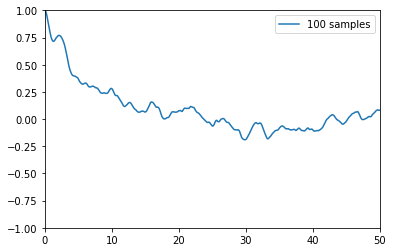

In [12]:
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_100, label="100 samples")
#plt.plot(np.linspace(0, duration, N_steps), sigma_zs_1000, label="1000 samples")
plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.legend()
plt.show()

In [352]:
options = {
    'linear' : False,
    'use_noise' : False,
    'chi_max' : 10,
    'eps' : 0,
    'method' : 'RK4',
    'physical' : False,
}

In [353]:
my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)

non physical


In [354]:
psi_no_noise = my_homps.compute_realizations(N_samples=1, progressBar=tqdm)

  0%|          | 0/1 [00:00<?, ?it/s]

In [355]:
sigma_zs = compute_exp_val_nonlinear(psi_no_noise, sigma_z)

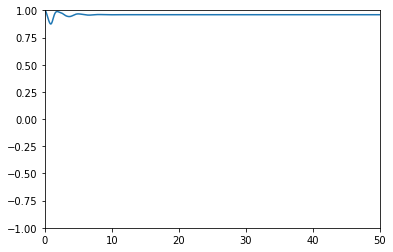

In [356]:
plt.plot(np.linspace(0, duration, N_steps), sigma_zs)
plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.show()

# High T, low damping

In [64]:
# Parameters for the spin-boson model
epsilon = 2.0
delta = -2.0
# Parameters for the Debye spectral density
beta = 0.5
T = 1/beta
gamma = 0.25
eta = 0.5
# operators
sigma_x, sigma_z, eye = operators.generate_physical_operators()
L = sigma_z
h = operators.generate_spin_boson_hamiltonian(delta=delta, epsilon=epsilon)
# time window
duration = 30

In [65]:
N_terms = 1
g, w = debye_spectral_density.get_debye_coefficients(N_terms, T, gamma, eta)
N_terms_noise = 5000
g_noise, w_noise = debye_spectral_density.get_debye_coefficients(N_terms_noise, T, gamma, eta)

In [66]:
N_steps = 500
N_trunc = 40

In [100]:
N_memory = 4

## FFT noise

In [101]:
alpha = lambda tau : bath_correlation_function.alpha(tau, g_noise, w_noise)

In [102]:
options = {
    'linear' : False,
    'use_noise' : True,
    'chi_max' : 10,
    'eps' : 0,
    'method' : 'RK4',
    'rescale_aux' : True,
    'noise_generator' : noise_generator.ColoredNoiseGenerator_FourierFiltering(alpha, 0, duration),
    'g_memory' : g_noise[:N_memory],
    'w_memory' : w_noise[:N_memory],
}

In [103]:
my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)

In [104]:
psis_100_fft = my_homps.compute_realizations(100, progressBar=tqdm)

  0%|          | 0/100 [00:00<?, ?it/s]

In [49]:
psis_1000_fft = my_homps.compute_realizations(1000, progressBar=tqdm)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [105]:
sigma_zs_100_fft = compute_exp_val_nonlinear(psis_100_fft, sigma_z)
sigma_zs_1000_fft = compute_exp_val_nonlinear(psis_1000_fft, sigma_z)

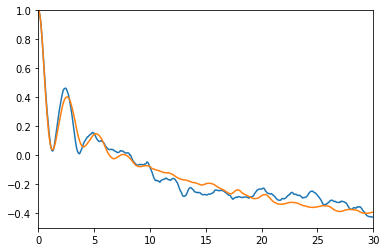

In [106]:
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_100_fft)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_1000_fft)
plt.ylim(-.5, 1.)
plt.xlim(0,30)
plt.show()

## Sum approx noise

In [107]:
N = 10000
w_cut = 1000
J = lambda w : debye_spectral_density.debye_spectral_density(w, eta, gamma)

In [108]:
generator = noise_generator.ColoredNoiseGenerator_SumApprox(J, 0, duration, N, w_cut, beta)

In [111]:
options = {
    'linear' : False,
    'use_noise' : True,
    'chi_max' : 10,
    'eps' : 0,
    'method' : 'RK4',
    'rescale_aux' : True,
    'noise_generator' : generator,
    'g_memory' : g_noise[:N_memory],
    'w_memory' : w_noise[:N_memory],
}

In [112]:
my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)

In [113]:
psis_100_sum_approx = my_homps.compute_realizations(100, progressBar=tqdm)

  0%|          | 0/100 [00:00<?, ?it/s]

In [52]:
psis_1000_sum_approx = my_homps.compute_realizations(1000, progressBar=tqdm)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [114]:
sigma_zs_100_sum_approx = compute_exp_val_nonlinear(psis_100_sum_approx, sigma_z)
sigma_zs_1000_sum_approx = compute_exp_val_nonlinear(psis_1000_sum_approx, sigma_z)

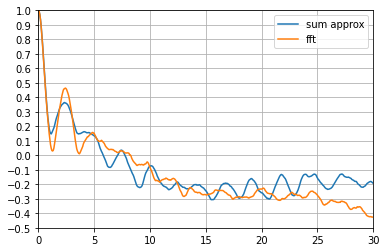

In [115]:
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_100_sum_approx, label="sum approx")
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_100_fft, label="fft")
plt.ylim(-0.5, 1)
plt.yticks(np.linspace(-0.5, 1, 16))
plt.xlim(0, duration)
plt.grid()
plt.legend()
plt.show()

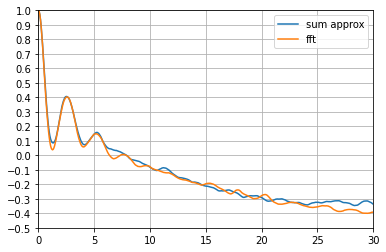

In [116]:
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_1000_sum_approx, label="sum approx")
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_1000_fft, label="fft")
plt.ylim(-0.5, 1)
plt.yticks(np.linspace(-0.5, 1, 16))
plt.xlim(0, duration)
plt.grid()
plt.legend()
plt.show()